# Работа с полным датасетом Omniglot

---



# Загрузка полного датасета Omniglot

Загрузка датасета

In [1]:
from sklearn.metrics import accuracy_score
from google.colab import drive

import numpy as np
import zipfile
import io
import os

NUMBER_OF_CLASSES = 1600
PATH = 'drive/My Drive/Few-Shot-Learning/Omniglot-data-set'

drive.mount('/content/drive')

with zipfile.ZipFile(os.path.join(PATH, 'train_images.zip')) as zipper:
    with io.BufferedReader(zipper.open('train_images.txt', mode='r')) as file:
        X_train = np.resize(np.loadtxt(file, dtype=np.uint8), (14 * NUMBER_OF_CLASSES, 1, 105, 105))
        
with zipfile.ZipFile(os.path.join(PATH, 'train_labels.zip')) as zipper:
    with io.BufferedReader(zipper.open('train_labels.txt', mode='r')) as file:
        y_train = np.resize(np.loadtxt(file, dtype='str'), (14 * NUMBER_OF_CLASSES))
        
with zipfile.ZipFile(os.path.join(PATH, 'test_images.zip')) as zipper:
    with io.BufferedReader(zipper.open('test_images.txt', mode='r')) as file:
        X_test = np.resize(np.loadtxt(file, dtype=np.uint8), (6 * NUMBER_OF_CLASSES, 1, 105, 105))
        
with zipfile.ZipFile(os.path.join(PATH, 'test_labels.zip')) as zipper:
    with io.BufferedReader(zipper.open('test_labels.txt', mode='r')) as file:
        y_test = np.resize(np.loadtxt(file, dtype='str'), (6 * NUMBER_OF_CLASSES))

Mounted at /content/drive


Определение трансформации

In [2]:
!pip install -q -U albumentations
import albumentations as A

from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.SmallestMaxSize(max_size=105),
                       A.CenterCrop(height=84, width=84),
                       A.Normalize(mean=(0.5), std=(0.5)),
                       ToTensorV2(),])

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 952kB 47.9MB/s 


Определение тензоров

In [3]:
import torch

train_images = torch.stack([transform(image=x[0])["image"] for x in X_train]).float()
test_images = torch.stack([transform(image=x[0])["image"] for x in X_test]).float()

classes = [y_train[14 * i] for i in range(NUMBER_OF_CLASSES)]

train_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(14)])).long()
test_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(6)])).long()

Определение вспомогательной функции для подготовки выборки

In [4]:
def shuffle_tensor(images, labels, batch_size, count=14):
    perm = torch.randperm(count * NUMBER_OF_CLASSES)

    images = images[perm].view(count * NUMBER_OF_CLASSES // batch_size, batch_size, 1, 84, 84).float()
    labels = labels[perm].view(count * NUMBER_OF_CLASSES // batch_size, batch_size).long()

    return list(zip(images, labels))
    

def shuffle_tensor_tuple(images, labels, batch_size, count=14):
    perm = torch.randperm(count * NUMBER_OF_CLASSES)

    images = images[perm].view(count * NUMBER_OF_CLASSES // 2 // batch_size, 2, batch_size, 1, 84, 84).float()
    labels = labels[perm].view(count * NUMBER_OF_CLASSES // 2 // batch_size, 2, batch_size).long()

    return list(zip(images, labels))

# Визуализация датасета Omniglot (полный датасет)

label: ULOG_03


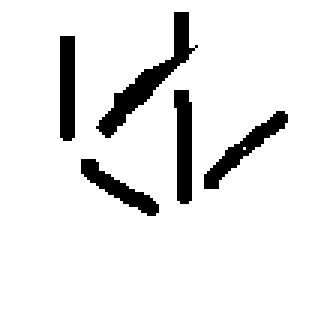

In [5]:
from PIL import Image

digit_number = -1

image = Image.fromarray(X_train[digit_number].reshape(105, 105), mode='P')

print('label: {}'.format(y_train[digit_number]))
display(image.resize((315, 315)))

# Использование сиамской нейронной сети для решения задачи классификации рукописных символов (полный датасет)

Создание сиамской нейронной сети

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(32 * 19 * 19, 3600)
        self.fc2 = nn.Linear(3600, 480)

    def forward_once(self, x):
        x_out = F.relu(self.bnorm1(self.pool(self.conv1(x))))
        x_out = F.relu(self.bnorm2(self.pool(self.conv2(x_out))))
        x_out = x_out.view(-1, 32 * 19 * 19)
        x_out = F.relu(self.drop(self.fc1(x_out)))
        x_out = self.fc2(x_out)
        return x_out

    def forward(self, x_1, x_2):
        return self.forward_once(x_1), self.forward_once(x_2)

Определение функции потерь

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()

        self.margin = margin

    def forward(self, x_1, x_2, y):
        diff = x_1 - x_2
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)

        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x_1.size()[0]

        return loss

Обучение сиамской нейронной сети

In [ ]:
import torch.optim as optim

net = Net().cuda()

criterion = ContrastiveLoss(margin=800)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.0005)

net.train()

for iteration in range(10000):
    trainset = shuffle_tensor_tuple(train_images, train_labels, 350)

    for data in trainset:
        images, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        labels_pred = net(*images)
        loss = criterion(*labels_pred, (labels[0] == labels[1]).type(torch.uint8))

        loss.backward()
        optimizer.step()

Использование сиамской нейронной сети

In [28]:
def distance(x_1, x_2):
    return np.sqrt(np.sum((x_1 - x_2) ** 2, axis=1))

net.eval()

X_train_encoded = []
y_train_encoded = []

trainset = shuffle_tensor(train_images, train_labels, 350)

for images, labels in trainset:
    X_train_encoded.append(net.forward_once(images.cuda()).cpu().detach().numpy())
    y_train_encoded.append(labels.detach().numpy())

X_train_encoded = np.reshape(np.array(X_train_encoded), (-1, 480))
y_train_encoded = np.reshape(np.array(y_train_encoded), (-1))


X_test_encoded = []
y_test_encoded = []

testset = shuffle_tensor(test_images, test_labels, 300, 6)

for images, labels in testset:
    X_test_encoded.append(net.forward_once(images.cuda()).cpu().detach().numpy())
    y_test_encoded.append(labels.detach().numpy())

X_test_encoded = np.reshape(np.array(X_test_encoded), (-1, 480))
y_test_encoded = np.reshape(np.array(y_test_encoded), (-1))


predicted_s = []

for encoded in X_test_encoded:
    dists = distance(encoded, X_train_encoded)
    index = dists.argmin()

    predicted_s.append(y_train_encoded[index])

Вычисление метрик

In [29]:
print('accuracy {:.3}'.format(accuracy_score(y_test_encoded, predicted_s)))

accuracy 0.482


# Сравнение результатов работы сиамской нейронной сетей с рассмотренными ранее нейронными сетями для полного датасета Omniglot (полный датасет)

In [30]:
from sklearn.metrics import accuracy_score

print('Siamese Neural network accuracy: {:.3}'.format(accuracy_score(y_test_encoded, predicted_s)))

Siamese Neural network accuracy: 0.482


При переходе к полному датасету число классов увеличилось, но число обучающих объектов каждого класса осталось неизменным. Это привело к проблеме низкой вероятности попадания объектов одного класса в пару, которую пришлось решать новым подбором гиперпараметра отступа и увеличением числа эпох для обучения нейронной сети. Если сравнивать с уже рассмотренными архитектурами нейронных сетей, то данный подход хоть и позволил обогнать по метрике точности полносвязную и сверточную нейронные сети, но достичь результатов данных сетей с применением аугментации не представляется возможным. В целом такой результат показателя метрики точности, учитывая число классов данного примера задачи классификации, является более чем достойным.